In [1]:
# Install required libraries
# !pip install --upgrade pip
!pip install kaggle --upgrade
!pip install pretrainedmodels
# !pip install torchvision

# Add your PRIVATE credentials (you get them from https://www.kaggle.com > 'Account' > "Create new API token" )
# Do not use "!export KAGGLE_USERNAME= ..." OR "" around your credential
%env KAGGLE_USERNAME=qaqwsw123
%env KAGGLE_KEY=123

# Verify
!export -p | grep KAGGLE_

     |████████████████████████████████| 61kB 2.7MB/s 
     |████████████████████████████████| 81kB 7.8MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=2b26a50e76394a9ba1ee31335543e203d85672845be879a9d703c6735c23b923
  Stored in directory: /tmp/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
  Created wheel for python-slugify: filename=python_slugify-4.0.0-py2.py3-none-any.whl size=5487 sha256=5b256096bce365bf62d0eee9419e089bd1b9cff623b6bcbbad56c766ce3ed65c
  Stored in directory: /tmp/.cache/pip/wheels/11/94/81/312969455540cb0e6a773e5d68a73c14128bfdfd4a7969bb4f
Successfully built kaggle python-slugify
     |████████████████████████████████| 61kB 2.8MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60963 sha256=0234107a6ce7715e0a34f2764ac9aacddd9933603560a818b0ba090a0cbf74d2
  Stored in directory: /tmp/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59

In [2]:
from fastai.vision import *
import torchvision as tv
import pandas as pd
import os
from tqdm import tqdm # to see the running process
from skimage.io import imread, imshow # to read the image from workspace
from skimage.transform import resize # resize those data to a certain size for training

In [3]:
!unzip /kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip -d /dev/shm
# !unzip /kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip -d /dev/shm
!cp /kaggle/input/dog-final/test /dev/shm -r

Archive:  /kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip
   creating: /dev/shm/train/
  inflating: /dev/shm/train/cat.0.jpg  
  inflating: /dev/shm/train/cat.1.jpg  
  inflating: /dev/shm/train/cat.10.jpg  
  inflating: /dev/shm/train/cat.100.jpg  
  inflating: /dev/shm/train/cat.1000.jpg  
  inflating: /dev/shm/train/cat.10000.jpg  
  inflating: /dev/shm/train/cat.10001.jpg  
  inflating: /dev/shm/train/cat.10002.jpg  
  inflating: /dev/shm/train/cat.10003.jpg  
  inflating: /dev/shm/train/cat.10004.jpg  
  inflating: /dev/shm/train/cat.10005.jpg  
  inflating: /dev/shm/train/cat.10006.jpg  
  inflating: /dev/shm/train/cat.10007.jpg  
  inflating: /dev/shm/train/cat.10008.jpg  
  inflating: /dev/shm/train/cat.10009.jpg  
  inflating: /dev/shm/train/cat.1001.jpg  
  inflating: /dev/shm/train/cat.10010.jpg  
  inflating: /dev/shm/train/cat.10011.jpg  
  inflating: /dev/shm/train/cat.10012.jpg  
  inflating: /dev/shm/train/cat.10013.jpg  
  inflating: /dev/shm/train/cat.10014

In [5]:
data_path='/kaggle/input/dogs-vs-cats-redux-kernels-edition/'
pre_path= '/dev/shm/'
path = Path(pre_path+'train')
# test = [ImageList.from_df(df, path=test_path, cols='ID', folder=folder, suffix='.jpg') 
#                for df, folder in zip([ test_df], [ 'test'])]

test_path =  Path(pre_path+'test')

In [6]:
import cv2

for get_name in tqdm(os.listdir(path)):
    image_name = str(path)+'/'+get_name
    print(image_name)
    img = cv2.imread(image_name, cv2.IMREAD_UNCHANGED)
    break
# read image

 
# get dimensions of image
dimensions = img.shape
print(dimensions)


  0%|          | 0/25000 [00:00<?, ?it/s]

/dev/shm/train/dog.9999.jpg
(150, 96, 3)


In [7]:

# perform image augmentations to enhance training data
# tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=10.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75)
# tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4, p_affine=1., p_lighting=1.)

data = (ImageList.from_folder(path)
        .split_by_rand_pct(0.3, seed=2)
#         .label_from_folder()
        .label_from_re(r'([^/]+)\.\d+.jpg$')
        .add_test_folder(test_path)
        .transform(tfms, size=224,padding_mode='reflection')
        .databunch( bs=64, device= torch.device('cuda:0'))
        .normalize(imagenet_stats)
       )

In [8]:
data.classes

['cat', 'dog']

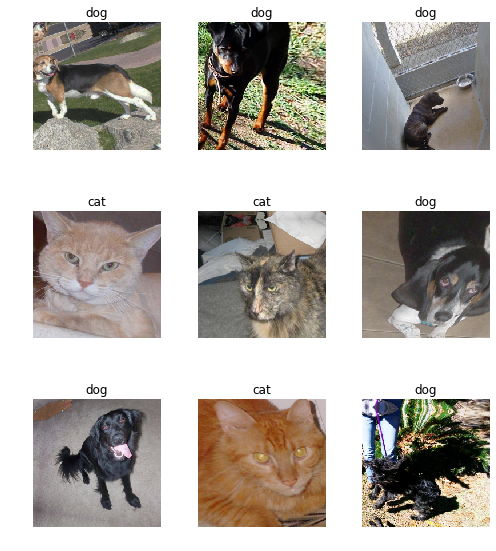

In [9]:
data.show_batch(rows=3, figsize=(7,8))

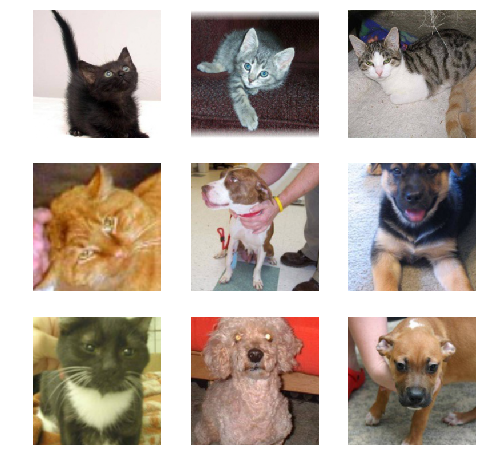

In [10]:
def _plot(i,j,ax):
        x,y = data.test_ds[i*3+j]
        x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [11]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['cat', 'dog'], 2, 17500, 7500)

In [12]:
import torch
import torch.nn as nn
from torch.utils.model_zoo import load_url as load_state_dict_from_url


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

 
class ResNet(nn.Module):
    glo_block=0
    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        glo_block= block.expansion
        print(f"num_class:{num_classes},block_expansion={glo_block}")
        
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:      
        pretrained_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model_dict = model.state_dict()
        pretrained_dict =  {k: v for k, v in pretrained_dict.items() if k in model_dict}
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)
    print(f"--block_expansion={block.expansion}")
    #Change 1000 class to 2 class
    model.fc= nn.Linear(512*block.expansion,2)
    return model


def resnet18(pretrained=False, progress=True, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)


def resnet34(pretrained=False, progress=True, **kwargs):
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    print(f"pretrained:{pretrained}")
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet50(pretrained=False, progress=True, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet101(pretrained=False, progress=True, **kwargs):
    r"""ResNet-101 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress,
                   **kwargs)


def resnet152(pretrained=False, progress=True, **kwargs):
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
                   **kwargs)


def resnext50_32x4d(pretrained=False, progress=True, **kwargs):
    r"""ResNeXt-50 32x4d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet('resnext50_32x4d', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def resnext101_32x8d(pretrained=False, progress=True, **kwargs):
    r"""ResNeXt-101 32x8d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnet('resnext101_32x8d', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)


def wide_resnet50_2(pretrained=False, progress=True, **kwargs):
    r"""Wide ResNet-50-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet50_2', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def wide_resnet101_2(pretrained=False, progress=True, **kwargs):
    r"""Wide ResNet-101-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet101_2', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)

In [13]:
from fastai.callbacks import *
# custom_head=custom_head,
wd=1e-1
learn = cnn_learner(data, resnet50,pretrained=True ,wd=wd,bn_final=True , metrics=[accuracy, AUROC()])
#                     ,callback_fns=[partial(EarlyStoppingCallback, monitor='auroc', min_delta=0.001, patience=3)]
#                    ) 
#         ,loss_func= nn.CrossEntropyLoss
# learn = cnn_learner(data, models.resnet34, metrics=error_rate,bn_final=True)

num_class:1000,block_expansion=4


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 59.0MB/s]


--block_expansion=4


In [14]:
# learn.fit_one_cycle(4)
learn.fit_one_cycle(6, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.163126,0.104881,0.987733,0.998928,04:00
1,0.104008,0.052482,0.988267,0.999078,04:00
2,0.054891,0.029844,0.990933,0.999571,04:04
3,0.045780,0.042071,0.985200,0.999407,04:01
4,0.048847,0.026433,0.991333,0.999384,03:52
5,0.040206,0.036062,0.991200,0.999276,03:51


In [15]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [16]:
learn.model_dir= '/kaggle/working/'

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Failed to compute the gradients, there might not be enough points.


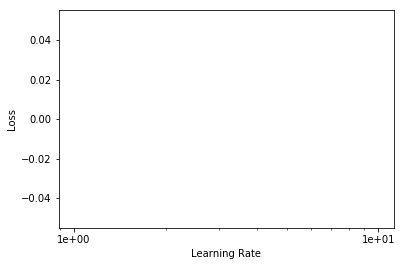

In [17]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [18]:
# learn.save('stage-1')
# learn.load('stage-1')


In [19]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,5e-5),pct_start=0.8)

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.032327,0.032369,0.992400,0.999266,04:01
1,0.028709,0.034298,0.992133,0.999280,04:06
2,0.029596,0.032379,0.992667,0.999266,03:59


In [20]:
learn.save('stage-2')

## Make Submit


In [23]:
test_preds = learn.get_preds(DatasetType.Test)

In [24]:
test_df = pd.read_csv('/kaggle/input/ml100-final/sample_submission.csv')
test_df = test_df[["ID", "Predicted"]]
test_df['Predicted'] = test_preds[0][:,0]
# np.clip( test_df['Predicted'],a_min=0.005, a_max=0.995)

name_list=[]
for i in range(len(learn.data.test_ds.x)):
    image_path = learn.data.test_ds.x.items[i]
    image_name = re.search(r'([^/]+)$', f'{image_path}')[0].replace('.jpg', '')
    name_list.append(image_name)

names = np.asarray(name_list)
test_df['ID'] = names
test_df= test_df.sort_values(by=['ID'])
csv_path ='/kaggle/working/submission.csv'
test_df.to_csv(csv_path, header=["ID", "Predicted"], index=False)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [26]:
test_df.head()

,ID,Predicted
398,000,0.997712
399,001,0.998594
397,002,0.996742
385,003,0.002734
396,004,0.994538


In [1]:
import time
!cd /kaggle/working
!kaggle competitions submit -c ml-marathon-final -f submission.csv -m "Resnet34-512_2class_3fit_noPretr"
time.sleep(10)

# View results
!kaggle competitions submissions -c ml-marathon-final

系統找不到指定的路徑。
Traceback (most recent call last):
  File "c:\users\user\anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\user\anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\User\Anaconda3\Scripts\kaggle.exe\__main__.py", line 4, in <module>
  File "c:\users\user\anaconda3\lib\site-packages\kaggle\__init__.py", line 23, in <module>
    api.authenticate()
  File "c:\users\user\anaconda3\lib\site-packages\kaggle\api\kaggle_api_extended.py", line 149, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in C:\Users\User\.kaggle. Or use the environment method.
Traceback (most recent call last):
  File "c:\users\user\anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\user\anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\User\Anaconda3\Scripts\kag